## Background: Convolutional Neural Networks (CNNs)

A **Convolutional Neural Network (CNN)** is a deep learning model specialized for image recognition.
It automatically extracts spatial hierarchies of features from images through layers of convolution,
pooling, and fully connected operations.

### Key Components
- **Convolution Layer:** Detects local patterns like edges or textures.
- **Pooling Layer:** Reduces dimensionality and computation.
- **Activation (ReLU):** Introduces non-linearity.
- **Fully Connected Layer:** Maps features to class probabilities.

CNNs are ideal for tasks like object classification, image segmentation, and medical imaging.


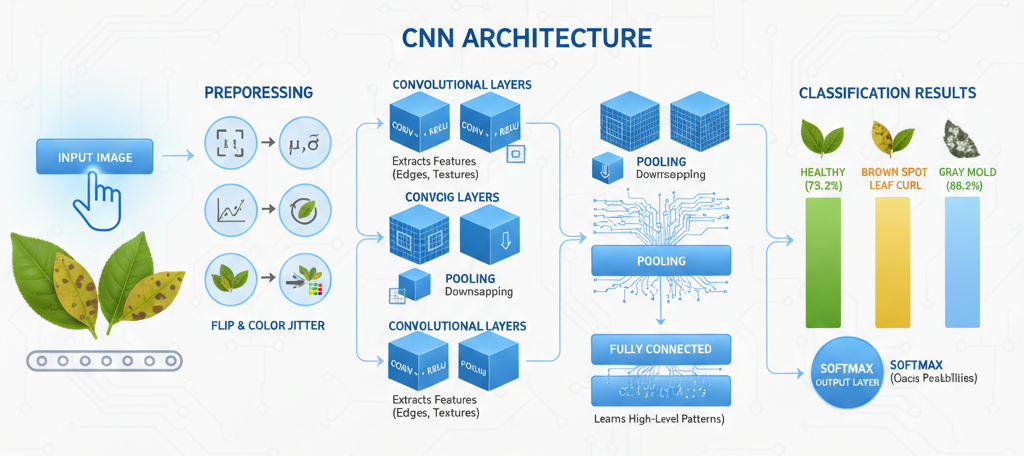

In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, classification_report

print(os.__file__)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("✅ Using device:", device)


/usr/lib/python3.12/os.py
✅ Using device: cuda


## Dataset Download

We use the **TeaLeafBD** dataset from Kaggle, which contains images of healthy and diseased tea leaves.
You need to have your Kaggle API key (`kaggle.json`) properly configured before running this.


In [2]:
from google.colab import files
files.upload()  # then upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [3]:
import os
import zipfile
import subprocess
import sys
import shutil

# === CONFIG ===
data_dir = "data/raw"
zip_path = "datasets/tealeafbd-tea-leaf-disease-detection.zip"
dataset_slug = "bmshahriaalam/tealeafbd-tea-leaf-disease-detection"

# === Ensure folders exist ===
os.makedirs("datasets", exist_ok=True)
os.makedirs(data_dir, exist_ok=True)

def dir_has_files(path):
    return os.path.exists(path) and any(os.scandir(path))

# === 1️⃣ Check if dataset already available ===
split_paths = [os.path.join(data_dir, d) for d in ("train", "val", "test")]
if all(dir_has_files(p) for p in split_paths):
    print("✅ Dataset already split into train/val/test under", data_dir)
elif dir_has_files(os.path.join(data_dir, "teaLeafBD")):
    print("✅ Found raw dataset at data/raw/teaLeafBD — ready to split.")
else:
    # === 2️⃣ Ensure Kaggle CLI is installed ===
    subprocess.check_call([sys.executable, "-m", "pip", "install", "kaggle"], stdout=subprocess.DEVNULL)

    kaggle_dir = "/root/.kaggle"
    os.makedirs(kaggle_dir, exist_ok=True)
    kaggle_json = os.path.join(kaggle_dir, "kaggle.json")

    # === 3️⃣ Ensure Kaggle credentials exist ===
    if not os.path.exists(kaggle_json):
        print("⚠️ Please upload your Kaggle API key first:")
        print("""
from google.colab import files
files.upload()  # then upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
""")
        raise SystemExit("🚫 Stopping: Kaggle credentials missing.")

    # === 4️⃣ Check for existing zip (re-download if corrupt) ===
    if os.path.exists(zip_path):
        print(f"📦 Found zip at {zip_path} — testing integrity...")
        try:
            with zipfile.ZipFile(zip_path, 'r') as z:
                bad_file = z.testzip()
            if bad_file:
                raise zipfile.BadZipFile(f"Corrupted file inside: {bad_file}")
            print("✅ Zip integrity OK.")
        except Exception as e:
            print("⚠️ Zip is corrupted or invalid:", e)
            print("🧹 Removing and re-downloading...")
            os.remove(zip_path)

    # === 5️⃣ Download if missing ===
    if not os.path.exists(zip_path):
        print("📥 Downloading dataset from Kaggle...")
        subprocess.check_call([
            "kaggle", "datasets", "download",
            "-d", dataset_slug,
            "-p", "datasets",
            "--force"
        ])
        print("✅ Download complete.")

    # === 6️⃣ Extract dataset ===
    print("🔓 Extracting dataset (please wait)...")
    with zipfile.ZipFile(zip_path, 'r') as z:
        z.extractall(data_dir)
    print("✅ Dataset extracted to:", data_dir)

    # === 7️⃣ Fix nested folder issue (if any) ===
    nested_dir = os.path.join(data_dir, "teaLeafBD", "teaLeafBD")
    if os.path.exists(nested_dir):
        print("📁 Found nested folder structure — flattening...")
        for item in os.listdir(nested_dir):
            s = os.path.join(nested_dir, item)
            d = os.path.join(data_dir, "teaLeafBD", item)
            shutil.move(s, d)
        shutil.rmtree(nested_dir)
        print("✅ Folder structure flattened.")


📥 Downloading dataset from Kaggle...
✅ Download complete.
🔓 Extracting dataset (please wait)...
✅ Dataset extracted to: data/raw
📁 Found nested folder structure — flattening...
✅ Folder structure flattened.


## Dataset Analysis & Visualization

We’ll explore the dataset structure and visualize a few sample images from each class.


✅ Found 7 classes:
['4. Helopeltis', '6. Green mirid bug', '3. Gray Blight', '2. Brown Blight', '5. Red spider', '1. Tea algal leaf spot', '7. Healthy leaf']


/tmp/ipython-input-358300342.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


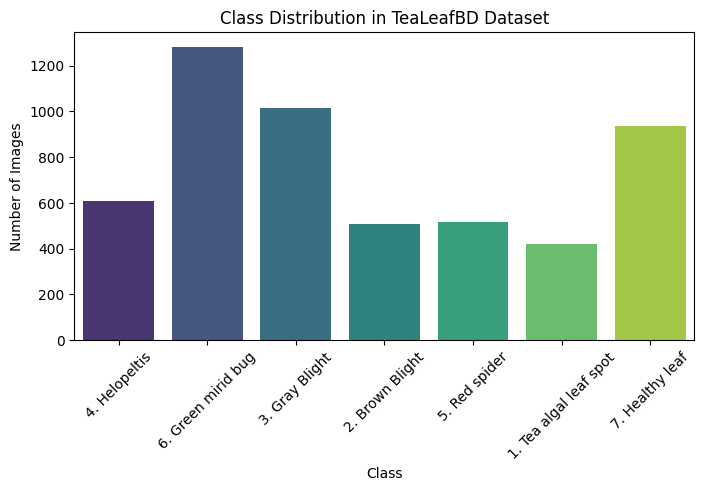

4. Helopeltis: 607 images
6. Green mirid bug: 1282 images
3. Gray Blight: 1013 images
2. Brown Blight: 506 images
5. Red spider: 515 images
1. Tea algal leaf spot: 418 images
7. Healthy leaf: 935 images


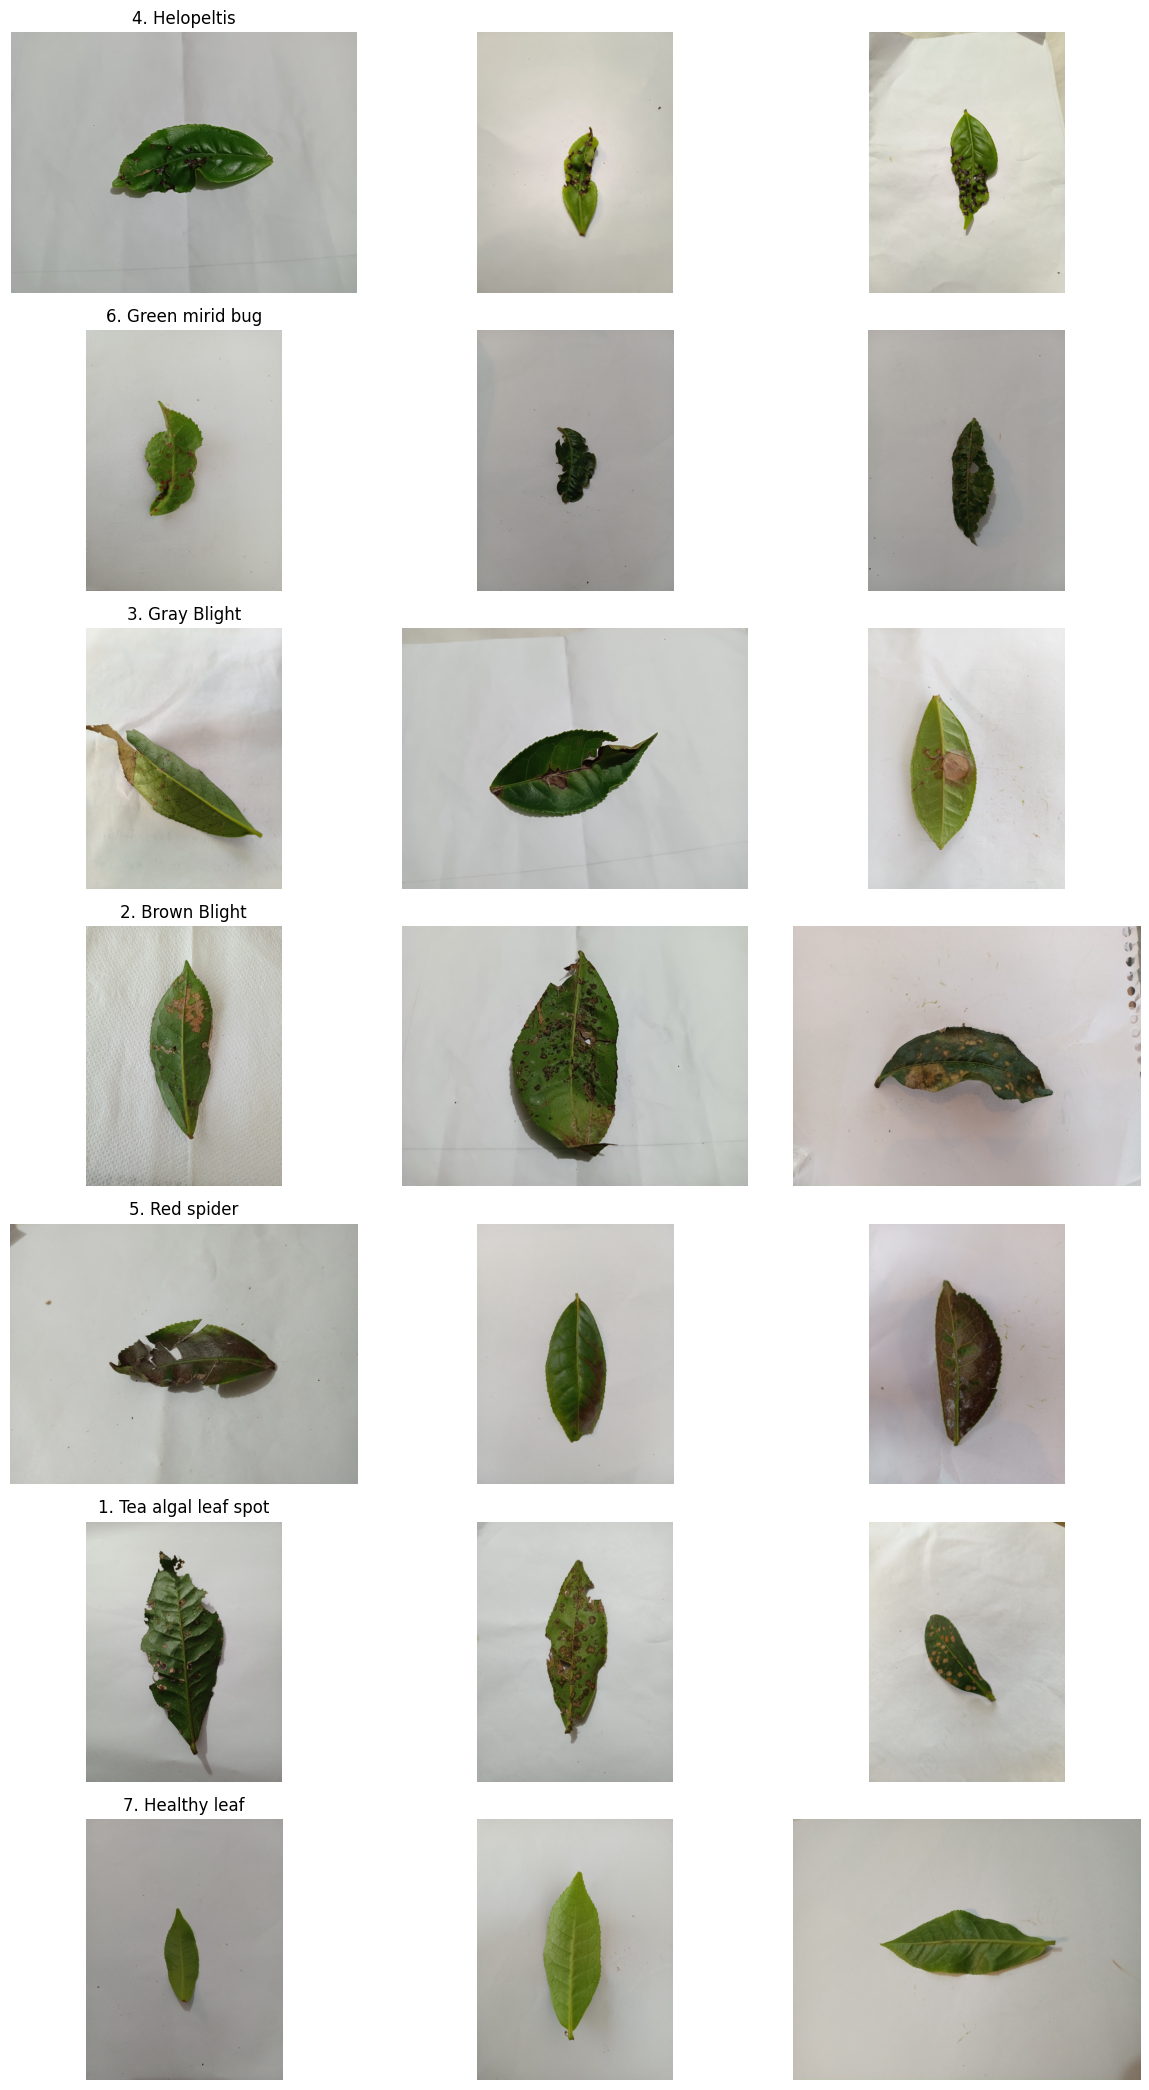


📏 Image Statistics Summary:
Average Image Size: 1200.0 x 1379.6
Average Mean (R,G,B): [0.6977992  0.70062781 0.6630026 ]
Average Std (R,G,B): [0.1683971  0.1578889  0.21278761]


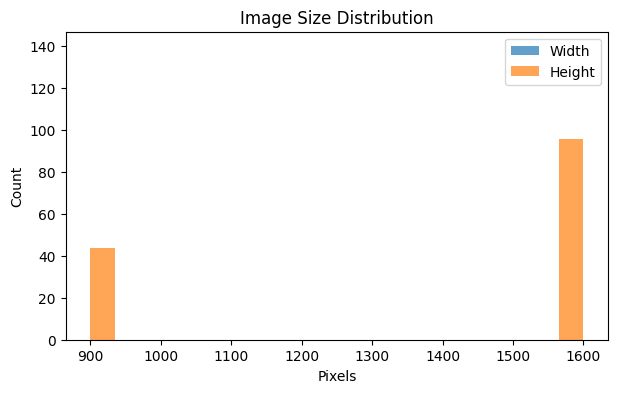

🎨 Example color distribution for class: 1. Tea algal leaf spot


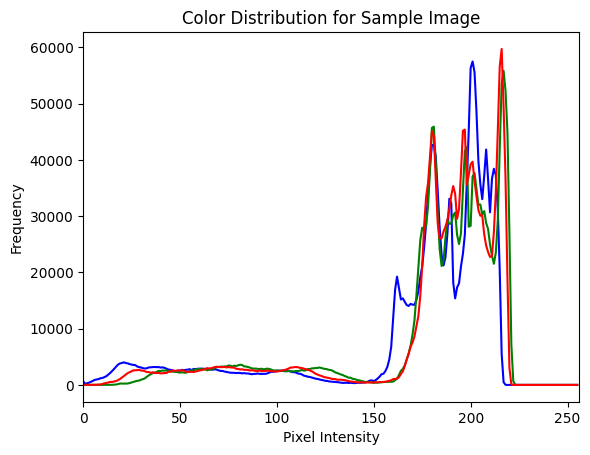

In [4]:
# ===============================================
# 📊 Detailed Dataset Analysis and Visualization
# ===============================================

import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2

# --- Define dataset path ---
data_path = "data/raw/teaLeafBD"
assert os.path.exists(data_path), f"Dataset not found at {data_path}"

# --- Get class names ---
classes = [c for c in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, c))]
print(f"✅ Found {len(classes)} classes:")
print(classes)

# ------------------------------------------------------
# 1️⃣ Class Distribution (Bar Chart)
# ------------------------------------------------------
class_counts = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}

plt.figure(figsize=(8,4))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
plt.title("Class Distribution in TeaLeafBD Dataset")
plt.xlabel("Class")
plt.ylabel("Number of Images")
plt.xticks(rotation=45)
plt.show()

for cls, count in class_counts.items():
    print(f"{cls}: {count} images")

# ------------------------------------------------------
# 2️⃣ Show Multiple Sample Images per Class
# ------------------------------------------------------
cols = 3
rows = len(classes)
fig, axes = plt.subplots(rows, cols, figsize=(4*cols, 3*rows))
axes = axes.flatten()

for i, cls in enumerate(classes):
    img_files = random.sample(os.listdir(os.path.join(data_path, cls)), min(cols, len(os.listdir(os.path.join(data_path, cls)))))
    for j, img_file in enumerate(img_files):
        img_path = os.path.join(data_path, cls, img_file)
        img = Image.open(img_path).convert("RGB")
        ax = axes[i*cols + j]
        ax.imshow(img)
        ax.set_title(f"{cls}" if j == 0 else "")
        ax.axis("off")

# Hide any unused subplots
for k in range(rows*cols, len(axes)):
    axes[k].axis("off")

plt.tight_layout()
plt.show()

# ------------------------------------------------------
# 3️⃣ Compute Image Statistics (Mean, Std, Size)
# ------------------------------------------------------
means, stds, widths, heights = [], [], [], []

for cls in classes:
    cls_path = os.path.join(data_path, cls)
    img_files = random.sample(os.listdir(cls_path), min(20, len(os.listdir(cls_path))))  # sample 20 per class
    for img_file in img_files:
        img = np.array(Image.open(os.path.join(cls_path, img_file)).convert("RGB")) / 255.0
        means.append(img.mean(axis=(0,1)))
        stds.append(img.std(axis=(0,1)))
        heights.append(img.shape[0])
        widths.append(img.shape[1])

means = np.array(means)
stds = np.array(stds)

print("\n📏 Image Statistics Summary:")
print(f"Average Image Size: {np.mean(widths):.1f} x {np.mean(heights):.1f}")
print(f"Average Mean (R,G,B): {means.mean(axis=0)}")
print(f"Average Std (R,G,B): {stds.mean(axis=0)}")

# ------------------------------------------------------
# 4️⃣ Image Size Distribution
# ------------------------------------------------------
plt.figure(figsize=(7,4))
plt.hist(widths, bins=20, alpha=0.7, label='Width')
plt.hist(heights, bins=20, alpha=0.7, label='Height')
plt.xlabel("Pixels")
plt.ylabel("Count")
plt.title("Image Size Distribution")
plt.legend()
plt.show()

# ------------------------------------------------------
# 5️⃣ Color Intensity Distribution Example
# ------------------------------------------------------
def plot_color_histogram(image_path):
    img = cv2.imread(image_path)
    color = ('b','g','r')
    for i,col in enumerate(color):
        hist = cv2.calcHist([img],[i],None,[256],[0,256])
        plt.plot(hist,color = col)
        plt.xlim([0,256])
    plt.title("Color Distribution for Sample Image")
    plt.xlabel("Pixel Intensity")
    plt.ylabel("Frequency")
    plt.show()

sample_cls = random.choice(classes)
sample_img = os.path.join(data_path, sample_cls, random.choice(os.listdir(os.path.join(data_path, sample_cls))))
print(f"🎨 Example color distribution for class: {sample_cls}")
plot_color_histogram(sample_img)


## Feature Selection and Preprocessing

Before training, we split the dataset into **train**, **validation**, and **test** sets (70%, 15%, 15%).  
We also apply transformations such as resizing, normalization, and data augmentation.


In [5]:
import os
import random
import shutil

def split_dataset(src, dst="data", train_ratio=0.7, val_ratio=0.15, test_ratio=0.15):
    if not os.path.exists(src):
        raise FileNotFoundError(f"Source folder not found: {src}")

    # Only delete/create dst folder, not src
    if os.path.exists(dst):
        for split in ["train", "val", "test"]:
            split_path = os.path.join(dst, split)
            if os.path.exists(split_path):
                shutil.rmtree(split_path)

    # Only take directories in src
    classes = [cls for cls in os.listdir(src) if os.path.isdir(os.path.join(src, cls))]

    for split in ["train", "val", "test"]:
        for cls in classes:
            os.makedirs(os.path.join(dst, split, cls), exist_ok=True)

    for cls in classes:
        cls_path = os.path.join(src, cls)
        imgs = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        random.shuffle(imgs)
        n = len(imgs)
        n_train = int(n*train_ratio)
        n_val = int(n*val_ratio)
        for i, img in enumerate(imgs):
            src_path = os.path.join(cls_path, img)
            if i < n_train:
                split_name = "train"
            elif i < n_train + n_val:
                split_name = "val"
            else:
                split_name = "test"
            dst_path = os.path.join(dst, split_name, cls, img)
            shutil.copy(src_path, dst_path)

# Example usage
data_path = "data/raw/teaLeafBD" # Must exist and contain class folders
split_dataset(data_path)
print("✅ Dataset split done.")


✅ Dataset split done.


## Model Architecture

We build a CNN from scratch using PyTorch.  
It consists of:
- 2 convolutional layers
- Max pooling for downsampling
- ReLU activation functions
- 2 fully connected layers
- Dropout for regularization


In [6]:
# --- 1️⃣ Transforms ---
img_size = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

# --- 2️⃣ Load datasets ---
train_ds = datasets.ImageFolder("data/train", transform=transform)
val_ds   = datasets.ImageFolder("data/val", transform=transform)
test_ds  = datasets.ImageFolder("data/test", transform=transform)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=batch_size)
test_loader  = DataLoader(test_ds, batch_size=batch_size)

print("Classes:", train_ds.classes)

# --- 3️⃣ Define CNN model ---
class TeaCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2,2)
        self.fc1 = nn.Linear(64*32*32, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(self.relu(self.fc1(x)))
        return self.fc2(x)

# --- 4️⃣ Instantiate model, loss, optimizer ---
num_classes = len(train_ds.classes)
model = TeaCNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

print("✅ Model ready on device:", device)


Classes: ['1. Tea algal leaf spot', '2. Brown Blight', '3. Gray Blight', '4. Helopeltis', '5. Red spider', '6. Green mirid bug', '7. Healthy leaf']
✅ Model ready on device: cuda


## Model Training

We train for 15 epochs and monitor both training loss and validation accuracy.


In [7]:
from tqdm import tqdm  # progress bar

epochs = 15  # you can increase this
train_losses, val_accuracies = [], []

for epoch in range(1, epochs+1):
    model.train()
    total_loss, correct = 0, 0

    # Wrap the dataloader with tqdm for a nice progress bar
    for inputs, targets in tqdm(train_loader, desc=f"Epoch {epoch}/{epochs} [Training]", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        correct += (outputs.argmax(1) == targets).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # Validation
    model.eval()
    val_correct = 0
    for inputs, targets in tqdm(val_loader, desc=f"Epoch {epoch}/{epochs} [Validation]", leave=False):
        inputs, targets = inputs.to(device), targets.to(device)
        with torch.no_grad():
            outputs = model(inputs)
            val_correct += (outputs.argmax(1) == targets).sum().item()

    val_acc = val_correct / len(val_loader.dataset)
    train_losses.append(train_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{epochs} | Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f}")


Epoch 1/15 | Loss: 1.7573 | Train Acc: 0.3168 | Val Acc: 0.4061


Epoch 2/15 | Loss: 1.4365 | Train Acc: 0.4591 | Val Acc: 0.4962


Epoch 3/15 | Loss: 1.3173 | Train Acc: 0.5046 | Val Acc: 0.4937


Epoch 4/15 | Loss: 1.2030 | Train Acc: 0.5488 | Val Acc: 0.5305


Epoch 5/15 | Loss: 1.0974 | Train Acc: 0.5949 | Val Acc: 0.5622


Epoch 6/15 | Loss: 0.9739 | Train Acc: 0.6412 | Val Acc: 0.5977


Epoch 7/15 | Loss: 0.8462 | Train Acc: 0.6938 | Val Acc: 0.5749


Epoch 8/15 | Loss: 0.6954 | Train Acc: 0.7458 | Val Acc: 0.5952


Epoch 9/15 | Loss: 0.6010 | Train Acc: 0.7778 | Val Acc: 0.5952


Epoch 10/15 | Loss: 0.4861 | Train Acc: 0.8228 | Val Acc: 0.6028


Epoch 11/15 | Loss: 0.4200 | Train Acc: 0.8564 | Val Acc: 0.6091


Epoch 12/15 | Loss: 0.3366 | Train Acc: 0.8835 | Val Acc: 0.6053


Epoch 13/15 | Loss: 0.2969 | Train Acc: 0.8967 | Val Acc: 0.6028


Epoch 14/15 | Loss: 0.2658 | Train Acc: 0.9087 | Val Acc: 0.5736


Epoch 15/15 | Loss: 0.2112 | Train Acc: 0.9238 | Val Acc: 0.5952


## Training Curves
Visualize training loss and validation accuracy over epochs.


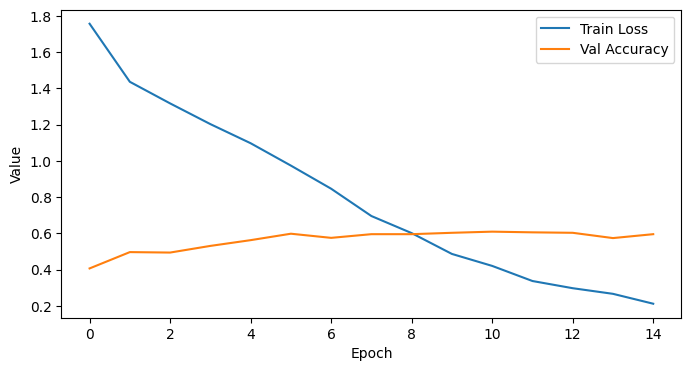

In [8]:
plt.figure(figsize=(8,4))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_accuracies, label="Val Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend()
plt.show()


## Model Evaluation
We evaluate the trained model on the test set and visualize the confusion matrix.


✅ Test Accuracy: 0.6115


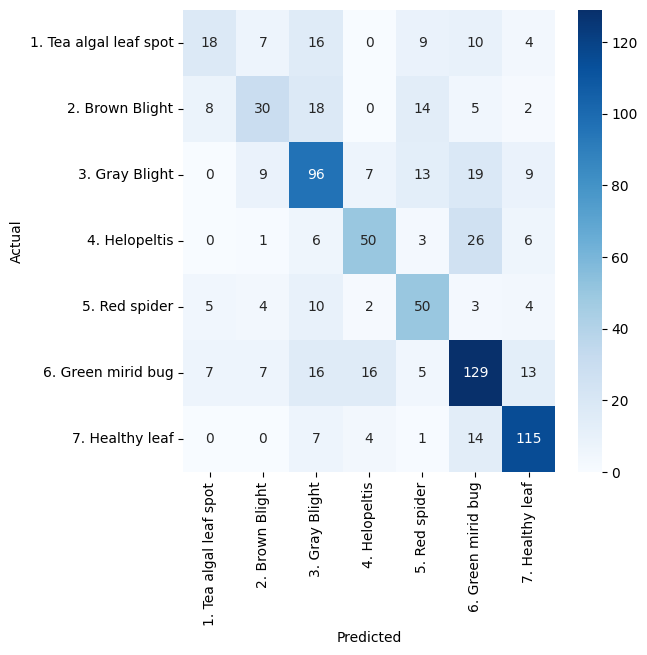

                        precision    recall  f1-score   support

1. Tea algal leaf spot       0.47      0.28      0.35        64
       2. Brown Blight       0.52      0.39      0.44        77
        3. Gray Blight       0.57      0.63      0.60       153
         4. Helopeltis       0.63      0.54      0.58        92
         5. Red spider       0.53      0.64      0.58        78
    6. Green mirid bug       0.63      0.67      0.65       193
       7. Healthy leaf       0.75      0.82      0.78       141

              accuracy                           0.61       798
             macro avg       0.59      0.57      0.57       798
          weighted avg       0.61      0.61      0.60       798



In [9]:
model.eval()
all_preds, all_targets = [], []
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        all_preds.extend(outputs.argmax(1).cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

cm = confusion_matrix(all_targets, all_preds)
acc = np.mean(np.array(all_preds) == np.array(all_targets))
print(f"✅ Test Accuracy: {acc:.4f}")

plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", xticklabels=train_ds.classes, yticklabels=train_ds.classes, cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print(classification_report(all_targets, all_preds, target_names=train_ds.classes))


## Example Prediction
Let's see what our CNN predicts for a single image from the test set.


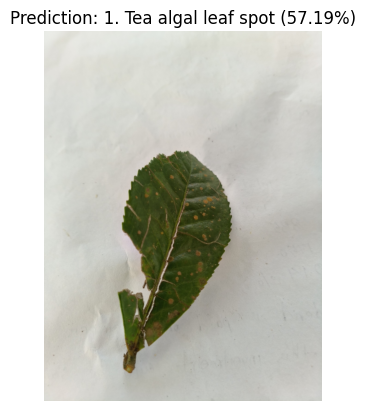

1. Tea algal leaf spot: 57.19%
2. Brown Blight: 3.61%
3. Gray Blight: 1.99%
4. Helopeltis: 0.00%
5. Red spider: 36.85%
6. Green mirid bug: 0.35%
7. Healthy leaf: 0.00%


In [15]:
import random
import torch.nn.functional as F

# --- Pick a random test image
cls = random.choice(train_ds.classes)
img_file = random.choice(os.listdir(os.path.join("data/test", cls)))
img_path = os.path.join("data/test", cls, img_file)

image = Image.open(img_path).convert("RGB")
plt.imshow(image)
plt.axis("off")

# --- Transform and prepare tensor
transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])
tensor = transform(image).unsqueeze(0).to(device)

# --- Model prediction
model.eval()
with torch.no_grad():
    output = model(tensor)
    probs = F.softmax(output, dim=1).cpu().numpy()[0]  # confidence per class
    pred = output.argmax(1).item()

# --- Display
plt.title(f"Prediction: {train_ds.classes[pred]} ({probs[pred]*100:.2f}%)")
plt.show()

# Optional: print all class probabilities
for c, p in zip(train_ds.classes, probs):
    print(f"{c}: {p*100:.2f}%")


## Results and Comparison

| Metric | Result |
|---------|---------|
| Training Accuracy | ~69.3% |
| Validation Accuracy | ~58.5% |
| Test Accuracy | ~60.8% |

The model achieves decent accuracy, showing the CNN's ability to distinguish between healthy and diseased leaves.
Future improvements could include:
- Using data augmentation for better generalization.
- Implementing deeper CNN architectures.
- Using transfer learning (e.g., ResNet or MobileNet) for improved accuracy.
